# Long-term

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('seaborn-notebook')
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
import seaborn as sns
import math
import gc
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import random

%matplotlib inline

### Model inputs

In [3]:
import Inputs
from Inputs import *

C:\Users\larsasp\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\common.py:1920: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype)


In the model health states are declared as:
- a0: *susceptible to both breast - and ovarian cancer*
- a1: *susceptible to ovarian cancer only (assumed not susceptible to a second (relative) or third (index) round of bc*
- a2: *susceptible to breast cancer only (survivor of ovarian cancer)*
- b0: *breast cancer diagnosis*
- b1: *breast cancer stage 1*
- b2: *breast cancer stage 2*
- b3: *breast cancer stage 3*
- b4: *breast cancer stage 4*
- c0: *ovarian cancer diagnosis*
- c1: *ovarian cancer local*
- c2: *ovarian cancer regional*
- c3: *ovarian cancer distant*
- d0: *prophylactic masectomy and oophorectomy*
- d1: *prophylactic masectomy only*
- d2: *prophylactic oophorectomy only*
- e0: *no increased risk for cancer in respective organs (following successful d0)*
- f0: *dead from any cause ('normal' mortality + exces mortality due to organ specific cancer)*
- f1: *dead from breast cancer*
- f2: *dead from ovarian cancer*

#### Transition probability sets

In [4]:
## From a0
# Transition probabilities
def tp_a0b0(age):
    return rb(age)
def tp_a0c0(age):
    return ro(age)
def tp_a0d0():
    return mo()
def tp_a0d1():
    return ma()
def tp_a0d2():
    return oo()
def tp_a0f0(age):
    return mb(age)

# Complete probability set from state
def from_a0(age):
    """
    Needs to be treated as array of occuring events
    """
    true_pr_a0 = [
        (1 - (tp_a0b0(age) + tp_a0c0(age) + tp_a0d0() + tp_a0d1() + tp_a0d2() + tp_a0f0(age))),
        tp_a0b0(age),
        tp_a0c0(age),
        tp_a0d0(),
        tp_a0d1(),
        tp_a0d2(),
        tp_a0f0(age)
                  ]
# Event for agent each step| transition probabilities, own age
    a0 = np.random.multinomial(1, pvals = true_pr_a0)
    return a0

In [5]:
## From a1
# Transition probabilties
def tp_a1c0(age):
    return ro(age)
def tp_a1d2():
    return oo()
def tp_a1f0(age):
    return mb(age)

# Complete probability set from state
def from_a1(age):
    """
    Needs to be treated as array of occuring events
    """
    true_pr_a1 = [
        (1 - (tp_a1c0(age) + tp_a1d2() + tp_a1f0(age))),
        tp_a1c0(age),
        tp_a1d2(),
        tp_a1f0(age)
                ]
# Event for agent each step | transition probabilities, own age
    a1 = np.random.multinomial(1, pvals = true_pr_a1)
    return a1

In [6]:
## From a2 

# Transition probabilities
def tp_a2b0r(age):
    return bcr(age)
def tp_a2b0(age):
    return rb(age)
def tp_a2d1():
    return ma()
def tp_a2f0(age):
    return mb(age)

# Complete probability set from state
def from_a2r(age):
    true_pr_a2r = [
        (1 - (tp_a2b0r(age) + tp_a2d1() + tp_a2f0(age))),
        tp_a2b0r(age),
        tp_a2d1(),
        tp_a2f0(age)
                ]
# Event for agent each step | transition probabilities, own age
    a2r = np.random.multinomial(1, pvals = true_pr_a2r)
    return a2r


# Complete probability set from state
def from_a2(age):
    """
    Needs to be treated as array of occuring events
    """
    true_pr_a2 = [
        (1 - (tp_a2b0(age) + tp_a2d1() + tp_a2f0(age))),
        tp_a2b0(age),
        tp_a2d1(),
        tp_a2f0(age)
                ]
# Event for agent each step | transition probabilities, own age
    a2 = np.random.multinomial(1, pvals = true_pr_a2)
    return a2

In [7]:
## From b0
# Transition probabilities
def tp_b0b1(age):
    return bc1(age)
def tp_b0b2(age):
    return bc2(age)
def tp_b0b3(age):
    return bc3(age)
def tp_b0b4(age):
    return bc4(age)

# Complete probability set from state
def from_b0(age):
    """
    Needs to be treated as array of occuring events, e.g. (from_b0[0]==1) means 
    agent transfers to stage 1 bc.
    """
    true_pr_b0 = [
        tp_b0b1(age),
        tp_b0b2(age),
        tp_b0b3(age),
        tp_b0b4(age)
    ]
# Event for agent each step | transition probabilities, own age
    b0 = np.random.multinomial(1, pvals = true_pr_b0)
    return b0

In [8]:
## From b1
# Transition probabilties
def tp_b1(age):
    return m_bc1(age)

def from_b1(age, time_in_b1):
    true_pr_b1 = [(1 - tp_b1(age)), tp_b1(age), 0]
    if time_in_b1==10:
        true_pr_b1 = [0, 0, 1]
# Event for agent each step | transition probabilities, own age        
    b1 = np.random.multinomial(1, pvals = true_pr_b1)
    return b1

In [9]:
## From b2
# Transition probabilites
def tp_b2(age):
    return m_bc2(age)

def from_b2(age, time_in_b2):
    """
    If returning 1: agent survives untill next cycle
    Else: agent transfers to state f1 (bc specific mortality)
    If agent stays for a period of t = 10 cycles, she transfer out to state_a1
    """
    true_pr_b2 = [(1 - tp_b2(age)),
                  tp_b2(age),
                  0
                  ]
    if time_in_b2==10:
        true_pr_b2 = [0, 0, 1]
# Event for agent each step | transition probabilities, own age        
    b2 = np.random.multinomial(1, pvals= true_pr_b2)
    return b2

In [10]:
## From b3
# Transition probabilites
def tp_b3(age):
    return m_bc3(age)

def from_b3(age, time_in_b3):
    """
    If returning 1: agent survives untill next cycle
    Else: agent transfers to state f1 (bc specific mortality)
    If agent stays for a period of t = 10 cycles, she transfer out to state_a1
    """
    true_pr_b3 = [(1 - tp_b3(age)),
                  tp_b3(age),
                  0
                  ]
    if time_in_b3==10:
        true_pr_b3 = [0, 0, 1]
# Event for agent each step | transition probabilities, own age
    b3 = np.random.multinomial(1, pvals= true_pr_b3)
    return b3

In [11]:
## From b4
# Transition probabilites
def tp_b4(age):
    return m_bc4(age)

def from_b4(age, time_in_b4):
    """
    If returning 1: agent survives untill next cycle
    Else: agent transfers to state f1 (bc specific mortality)
    If agent stays for a period of t = 10 cycles, she transfer out to state_a1
    """
    true_pr_b4 = [(1 - tp_b4(age)),
                  tp_b4(age),
                  0
                  ]
    if time_in_b4==10:
        true_pr_b4 = [0, 0, 1]
# Event for agent each step | transition probabilities, own age        
    b4 = np.random.multinomial(1, pvals= true_pr_b4)
    return b4

In [12]:
## From c0
# Transition probabilities
def tp_c0c1():
    return ocl()
def tp_c0c2():
    return ocr()
def tp_c0c3():
    return ocd()

def from_c0():
    """
    Returns array with 1 or 0 for transition to each stage of ovarian cancer from diagnosis
    """
    true_pr_c0 = [
        tp_c0c1(),
        tp_c0c2(),
        tp_c0c3()
    ]
# Event for agent each step | transition probabilities, own age    
    c0 = np.random.multinomial(1, pvals = true_pr_c0)
    return c0

In [13]:
## From c1
# Transition probabilities
def tp_c1f2(age):
    return m_ocl(age)

def from_c1(age, time_in_c1):
    """
    Returns 1 if agent survives untill next cycle, 0 means agent dies from ovarian cancer
    and transfer to state_f2
    If agent stays for a period of t = 10 cycles, she transfer out to state_a2
    """
    true_pr_c1 = [(1 - tp_c1f2(age)),
                  tp_c1f2(age),
                  0
                  ]
    if time_in_c1==10: 
        true_pr_c1 = [0, 0, 1]
# Event for agent each step | transition probabilities, own age        
    c1 = np.random.multinomial(1, pvals = true_pr_c1)
    return c1

In [14]:
## From c2
# Transition probabilities
def tp_c2f2(age):
    return m_ocr(age)

def from_c2(age, time_in_c2):
    """
    Returns 1 if agent survives untill next cycle, 0 means agent dies from ovarian cancer
    and transfer to state_f2
    If agent stays for a period of t = 10 cycles, she transfer out to state_a2
    """
    true_pr_c2 = [(1 - tp_c2f2(age)),
                  tp_c2f2(age),
                  0
                  ]
    if time_in_c2==10: 
        true_pr_c2 = [0, 0, 1]
# Event for agent each step | transition probabilities, own age        
    c2 = np.random.multinomial(1, pvals = true_pr_c2)
    return c2

In [15]:
## From c3
# Transition probabilities
def tp_c3f2(age):
    return m_ocd(age)

def from_c3(age, time_in_c3):
    """
    Returns 1 if agent survives untill next cycle, 0 means agent dies from ovarian cancer
    and transfer to state_f2
    If agent stays for a period of t = 10 cycles, she transfer out to state_a2
    """
    true_pr_c3 = [(1 - tp_c3f2(age)),
                  tp_c3f2(age),
                  0
                  ]
    if time_in_c3==10: 
        true_pr_c3 = [0, 0, 1]
# Event for agent each step | transition probabilities, own age        
    c3 = np.random.multinomial(1, pvals = true_pr_c3)
    return c3

In [16]:
## From d0
# Transition probabilities
def tp_d0f0(age):
    return mb(age)

def from_d0(age):
    """
    Returns 1 if agent survives both masectomy and oophorectomy, 0 means agent dies from background mortality
    __Possible extension: include perioperative mortality for these surgeries
    """
    true_pr_d0 = (1 - tp_d0f0(age))
    d0 = np.random.binomial(1, p = true_pr_d0)
    return d0

In [17]:
## From d1
# Transition probabilties
def tp_d1f0(age):
    return mb(age)

def from_d1(age):
    """
    Returns 1 if agent survives prophylactic masectomy, 0 mean agent dies from background mortality
    __Possible extension: include perioperative mortality for pro. masec
    """
    true_pr_d1 = (1 - tp_d1f0(age))
# Event for agent each step | transition probabilities, own age    
    d1 = np.random.binomial(1, p = true_pr_d1)
    return d1

In [18]:
## From d2
# Transition probabilties
def tp_d2f0(age):
    return mb(age)

def from_d2(age):
    """
    Returns 1 if agent survives prophylactic oophorectomy, 0 mean agent dies from background mortality
    __Possible extension: include perioperative mortality for pro. oophore
    """
    true_pr_d2 = (1 - tp_d2f0(age))
# Event for agent each step | transition probabilities, own age    
    d2 = np.random.binomial(1, p = true_pr_d2)
    return d2

In [19]:
# From e0
def tp_e0f0(age):
    return mb(age)

def from_e0(age):
    """
    Returns 1 if agent survives untill next cycle, 0 mean agent dies from background mortaltiy
    State accessible only via d0, effectively removing increased mortaltiy risk from cancer in these organs
    """    
    true_pr_e0 = (1 - tp_e0f0(age))
# Event for agent each step | transition probabilities, own age    
    e0 = np.random(1, p = true_pr_e0)
    return e0

In [20]:
from mesa import Agent, Model

class Person(Agent):
    """An agent"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = 50
        self.state_a0 = 1
        self.state_a1 = 0
        self.state_a2 = 0
#        self.state_a2r = 0
        self.state_b0 = 0
        self.state_b1 = 0
        self.state_b2 = 0
        self.state_b3 = 0
        self.state_b4 = 0
        self.state_c0 = 0
        self.state_c1 = 0
        self.state_c2 = 0
        self.state_c3 = 0
        self.state_d0 = 0
        self.state_d1 = 0
        self.state_d2 = 0
        self.state_e0 = 0
        self.state_f0 = 0
        self.state_f1 = 0
        self.state_f2 = 0
        self.time_in_b1 = 0
        self.time_in_b2 = 0
        self.time_in_b3 = 0
        self.time_in_b4 = 0
        self.time_in_c1 = 0
        self.time_in_c2 = 0
        self.time_in_c3 = 0
        self.cycle = 0
        
    def step(self):
        """
        state a0 is the starting state for all agents in self.cycle = 0
        """
        if self.state_a0 == 1:
            if from_a0(age = self.age)[0] == 1:
                self.state_a0 += 0
                self.age += 1
            elif from_a0(age = self.age)[1] == 1:
                self.state_b0 += 1
                self.state_a0 -= 1
                self.age += 1
            elif from_a0(age = self.age)[2] == 1:
                self.state_c0 += 1
                self.state_a0 -= 1
                self.age += 1
            elif from_a0(age = self.age)[3] == 1:
                self.state_d0 += 1
                self.state_a0 -= 1
                self.age += 1
            elif from_a0(age = self.age)[4] == 1:
                self.state_d1 += 1
                self.state_a0 -= 1
                self.age += 1
            elif from_a0(age = self.age)[5] == 1:
                self.state_d2 += 1
                self.state_a0 -= 1
                self.age += 1
            else:
                self.state_f0 += 1
                self.state_a0 -= 1
                    
            if self.cycle > 0:
                
                if self.state_a1 == 1:
                    if from_a1(age = self.age)[0] == 1:
                        self.state_a1 += 0
                        self.age += 1
                    elif from_a1(age = self.age)[1] == 1:
                        self.state_c0 += 1
                        self.state_a1 -= 1
                        self.age += 1
                    elif from_a1(age = self.age)[2] == 2:
                        self.state_d2 += 1
                        self.state_a1 -= 1
                        self.age += 1
                    else:
                        self.state_f0 += 1
                        self.state_a1 -= 1
                        
                if self.state_a2 == 1:
                    if from_a2(age = self.age)[0] == 1:
                        self.state_a2 += 0
                        self.age += 1
                    if from_a2(age = self.age)[1] == 1:
                        self.state_b0 += 1
                        self.state_a2 -= 1
                        self.age += 1
                    if from_a2(age = self.age)[3] == 1:
                        self.state_d1 += 1
                        seøf.state_a2 -= 1
                        self.age += 1
                    else:
                        self.state_f0 += 1
                        self.state_a2 -= 1
                        
#                if self.state_a2r == 1:
#                    if from_a2r(age = self.age)[0] == 1:
#                        self.state_a2 += 0
#                        self.age += 1
#                    if from_a2r(age = self.age)[1] == 1:
#                        self.state_b0 += 1
#                        self.state_a2 -= 1
#                        self.age += 1
#                    if from_a2r(age = self.age)[3] == 1:
#                        self.state_d1 += 1
#                        seøf.state_a2 -= 1
#                        self.age += 1
#                    else:
#                        self.state_f0 += 1
#                        self.state_a2 -= 1

                if self.state_b0 == 1:
                    """
                    Do NOT append age variable, this is a tunnel state
                    """
                    if from_b0(age = self.age)[0] == 1:
                        self.state_b1 += 1
                        self.state_b0 -= 1
                    if from_b0(age = self.age)[1] == 1:
                        self.state_b2 += 1
                        self.state_b0 -= 1
                    if from_b0(age = self.age)[2] == 1:
                        self.state_b3 += 1
                        self.state_b0 -= 1
                    if from_b0(age = self.age)[3] == 1:
                        self.state_b4 += 1
                        self.state_b0 -= 1
                        
                if self.state_b1 == 1:
                    if from_b1(self.age, self.time_in_b1)[1] == 1:
                        self.state_f1 += 1
                        self.state_b1 -= 1   
                    elif from_b1(self.age, self.time_in_b1)[0] == 1:
                        self.state_b1 += 0
                        self.age += 1
                        self.time_in_b1 += 1
                        if self.time_in_b1==10:
                            self.state_a1 += 1
                            self.state_b1 -= 1
                            self.age += 1
                            self.time_in_b1 = 0


                if self.state_b2 == 1:
                    if from_b2(self.age, self.time_in_b2)[1] == 1:
                        self.state_f1 += 1
                        self.state_b2 -= 1          
                    elif from_b2(self.age, self.time_in_b2)[0] == 1:
                        self.state_b2 += 0
                        self.age += 1
                        self.time_in_b2 += 1
                        if self.time_in_b2==10:
                            self.state_a1+=1
                            self.state_b2-=1
                            self.age += 1
                            self.time_in_b2 = 0

                        
                if self.state_b3 == 1:
                    if from_b3(self.age, self.time_in_b3)[1] == 1:
                        self.state_f1 += 1
                        self.state_b3 -= 1              
                    elif from_b3(self.age, self.time_in_b3)[0] == 1:
                        self.state_b3 += 0
                        self.age += 1
                        self.time_in_b3 += 1
                        if self.time_in_b3 == 10:
                            self.state_a1 += 1
                            self.state_b3 -= 1
                            self.age += 1
                            self.time_in_b3 = 0

                        
                if self.state_b4 == 1:
                    if from_b4(self.age, self.time_in_b4)[1] == 1:
                        self.state_f1 += 1
                        self.state_b4 -= 1   
                    elif from_b4(self.age, self.time_in_b4)[0] == 1:
                        self.state_b4 += 0
                        self.age += 1
                        self.time_in_b4 += 1
                        if self.time_in_b4 == 10:
                            self.state_a1 += 1
                            self.state_b4 -= 1
                            self.age += 1
                            self.time_in_b4 = 0
        
                
                if self.state_c0 == 1:
                    """
                    Do NOT append age variable, this is a tunnel state
                    """
                    if from_c0()[0] == 1:
                        self.state_c1 += 1
                        self.state_c0 -= 1
                    if from_c0()[1] == 1:
                        self.state_c2 += 1
                        self.state_c0 -= 1
                    if from_c0()[2] == 1:
                        self.state_c3 += 1
                        self.state_c0 -= 1
                        
                if self.state_c1 == 1:
                    if from_c1(age = self.age, time_in_c1 = self.time_in_c1)[0] == 1:
                        self.state_c1 +=0
                        self.age += 1
                        self.time_in_c1 += 1
                        if self.time_in_c1 == 10:
                            """
                            With 10 cycles in state_c1, agent transfers to state_a2
                            """
                            self.state_a2 += 1
                            self.state_c1 -= 1
                            self.age += 1
                            self.time_in_c1 = 0
                    if from_c1(age = self.age, time_in_c1 = self.time_in_c1)[1] == 1:
                        self.state_f2 += 1
                        self.state_c1 -= 1
                        
                if self.state_c2 == 1:
                    if from_c2(age = self.age, time_in_c2 = self.time_in_c2)[0] == 1:
                        self.state_c2 +=0
                        self.age += 1
                        self.time_in_c2 += 1
                        if self.time_in_c2 == 10:
                            """
                            With 10 cycles in state_c2, agent transfers to state_a2
                            """
                            self.state_a2 += 1
                            self.state_c2 -= 1
                            self.age += 1
                            self.time_in_c2 = 0
                    if from_c2(age = self.age, time_in_c2 = self.time_in_c2)[1] == 1:
                        self.state_f2 += 1
                        self.state_c2 -= 1
                
                if self.state_c3 == 1:
                    if from_c3(age = self.age, time_in_c3 = self.time_in_c3)[0] == 1:
                        self.state_c3 +=0
                        self.age += 1
                        self.time_in_c3 += 1
                        if self.time_in_c3 == 10:
                            """
                            With 10 cycles in state_c3, agent transfers to state_a2
                            """
                            self.state_a2 += 1
                            self.state_c3 -= 1
                            self.age += 1
                            self.time_in_c3 = 0
                    if from_c3(age = self.age, time_in_c3 = self.time_in_c3)[1] == 1:
                        self.state_f2 += 1
                        self.state_c3 -= 1
                        
                if self.state_d0 == 1:
                    if from_d0(age = self.age) == 1:
                        self.state_d0 += 0
                        self.age += 1
                    else:
                        self.state_f0 += 1
                        self.state_d0 -= 1
                        
                if self.state_d1 == 1:
                    if from_d1(age = self.age) == 1:
                        self.state_d1 += 0
                        self.age += 1
                    else:
                        self.state_f0 += 1
                        self.state_d1 -= 1        
                        
                if self.state_d2 == 1:
                    if from_d2(age = self.age) == 1:
                        self.state_d2 += 0
                        self.age += 1
                    else:
                        self.state_f0 += 1
                        self.state_d2 -= 1
                        
                if self.state_e0 == 1:
                    if from_e0(age = self.age) == 1:
                        self.state_e0 += 0
                        self.age += 1
                    else:
                        self.state_f0 += 1
                        self.state_e0 -= 1
                        
        self.cycle += 1

In [21]:
def trace_a0(model):
    agent_a0 = [agent.state_a0 for agent in model.schedule.agents]
    x = sum(agent_a0)
    N = model.num_agents
    B = x / N
    return x

def trace_a1(model):
    agent_a1 = [agent.state_a1 for agent in model.schedule.agents]
    x = sum(agent_a1)
    N = model.num_agents
    B = x / N
    return x

def trace_a2(model):
    agent_a2 = [agent.state_a2 for agent in model.schedule.agents]
    x = sum(agent_a2)
    N = model.num_agents
    B = x / N
    return x

#def trace_A2r(model):
#    agent_a2r = [agent.state_A2r for agent in model.schedule.agents]
#    x = sum(agent_a2r)
#    N = model.num_agents
#    B = x / N
#    return B

def trace_b1(model):
    agent_b1 = [agent.state_b1 for agent in model.schedule.agents]
    x = sum(agent_b1)
    N = model.num_agents
    B = x / N
    return x

def trace_b2(model):
    agent_b2 = [agent.state_b2 for agent in model.schedule.agents]
    x = sum(agent_b2)
    N = model.num_agents
    B = x / N
    return x

def trace_b3(model):
    agent_b3 = [agent.state_b3 for agent in model.schedule.agents]
    x = sum(agent_b3)
    N = model.num_agents
    B = x / N
    return x

def trace_b4(model):
    agent_b4 = [agent.state_b4 for agent in model.schedule.agents]
    x = sum(agent_b4)
    N = model.num_agents
    B = x / N
    return x

def trace_bc_allstage(model):
    agent_bca = ([agent.state_b4 for agent in model.schedule.agents] 
                 +[agent.state_b2 for agent in model.schedule.agents]
                 +[agent.state_b3 for agent in model.schedule.agents]
                 +[agent.state_b4 for agent in model.schedule.agents])
    x = sum(agent_bca)
    N = model.num_agents
    B = x / N
    return x

def trace_c1(model):
    agent_c1 = [agent.state_c1 for agent in model.schedule.agents]
    x = sum(agent_c1)
    N = model.num_agents
    B = x / N
    return x

def trace_c2(model):
    agent_c2 = [agent.state_c2 for agent in model.schedule.agents]
    x = sum(agent_c2)
    N = model.num_agents
    B = x / N
    return x

def trace_c3(model):
    agent_c3 = [agent.state_c3 for agent in model.schedule.agents]
    x = sum(agent_c3)
    N = model.num_agents
    B = x / N
    return x

def trace_oc_allstage(model):
    agent_oca = ([agent.state_c1 for agent in model.schedule.agents]
                 +[agent.state_c2 for agent in model.schedule.agents]
                 +[agent.state_c3 for agent in model.schedule.agents])
    x = sum(agent_oca)
    N = model.num_agents
    B = x / N
    return x

def trace_e0(model):
    agent_e0 = [agent.state_e0 for agent in model.schedule.agents]
    x = sum(agent_e0)
    N = model.num_agents
    B = x / N
    return x

def trace_f0(model):
    agent_f0 = [agent.state_f0 for agent in model.schedule.agents]
    x = sum(agent_f0)
    N = model.num_agents
    B = x / N
    return x

def trace_f1(model):
    agent_f1 = [agent.state_f1 for agent in model.schedule.agents]
    x = sum(agent_f1)
    N = model.num_agents
    B = x / N
    return x

def trace_f2(model):
    agent_f2 = [agent.state_f2 for agent in model.schedule.agents]
    x = sum(agent_f2)
    N = model.num_agents
    B = x / N
    return x

In [22]:
class hboc(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.cycle  = 0
        self.schedule = RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            a = Person(i, self)
            self.schedule.add(a)    
        # Store data after each step
        self.datacollector = DataCollector(model_reporters=
                                           {"a0 Susceptible": trace_a0,
                                            "a1 BC survivor, OC susceptible": trace_a1,
                                            "a2 OC survivor, BC susceptible": trace_a2,
                                            "b BC all stages": trace_bc_allstage,
                                            "c OC all stages": trace_oc_allstage,
#                                            "b1": trace_b1,
#                                            "b2": trace_b2,
#                                            "b3": trace_b3,
#                                            "b4": trace_b4,
#                                            "c1": trace_c1,
#                                            "c2": trace_c2,
#                                            "c3": trace_c3,
                                            "e No increased risk": trace_e0,
                                            "f1 All cause mortality": trace_f0,
                                            "f2 BC specific mortality": trace_f1,
                                            "f3 OC specific mortality": trace_f2},
                                           agent_reporters=
                                           {"State_a0": lambda a: a.state_a0,
                                            "State_a1": lambda a: a.state_a1,
                                            "State_a2": lambda a: a.state_a2,
                                            "State_b1": lambda a: a.state_b1,
                                            "State_b2": lambda a: a.state_b2,
                                            "State_b3": lambda a: a.state_b3,
                                            "State_b4": lambda a: a.state_b4,
                                            "State_c1": lambda a: a.state_c1,
                                            "State_c2": lambda a: a.state_c2,
                                            "State_c3": lambda a: a.state_c3,
                                            "State_e0": lambda a: a.state_e0,
                                            "State_f0": lambda a: a.state_f0,
                                            "State_f1": lambda a: a.state_f1,
                                            "State_f2": lambda a: a.state_f2})
        
    def step(self):
        # store data  
        self.datacollector.collect(self)
                
        #advnace a step
        self.schedule.step()

In [23]:
model = hboc(1000)
for i in range(51):
    model.step()


In [24]:
all_agent_movement = model.datacollector.get_agent_vars_dataframe()
sum(all_agent_movement.State_a1)

0

In [25]:
output = model.datacollector.get_model_vars_dataframe()
output

,a0 Susceptible,"a1 BC survivor, OC susceptible","a2 OC survivor, BC susceptible",b BC all stages,c OC all stages,e No increased risk,f1 All cause mortality,f2 BC specific mortality,f3 OC specific mortality
0,1000,0,0,0,0,0,0,0,0
1,942,0,0,0,0,0,57,0,0
2,900,0,0,0,0,0,99,0,0
3,864,0,0,1,0,0,134,0,0
4,819,0,0,1,0,0,178,0,0
5,786,0,0,2,0,0,210,0,0
6,762,0,0,2,0,0,234,0,0
7,723,0,0,2,0,0,273,0,0
8,682,0,0,2,0,0,314,0,0
9,649,0,0,2,0,0,345,0,0


In [26]:
# Det ser kanskje ut som om koden har en bug som gjør at funksjonen med "dersom i state_bi" i 10 år -> a1, 
# den fungerer faktisk, men i o m at denne kreften er såpass sjelden på aggregert nivå, og at den har en økt dødelighet
# ser det slik ut. 

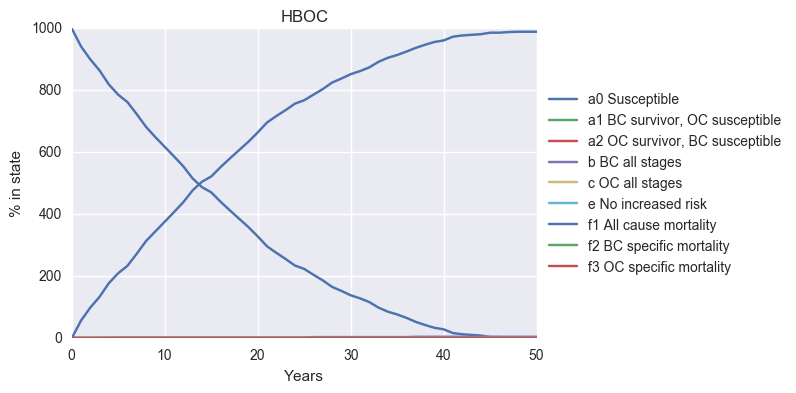

In [28]:
ax = output.plot()
ax.set_xlabel('Years')
ax.set_ylabel('% in state')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('HBOC')
#plt.savefig('M:\pc\Desktop\plot.png', dpi = 400)